# Imports and Reading the data

In [2]:
# Loading required packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt # pyplot as plt
import itertools
import shap

from dython.nominal import theils_u, correlation_ratio
import category_encoders as ce
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, roc_curve, roc_auc_score, precision_recall_curve

from sklearn import datasets, linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from pandas.api.types import is_numeric_dtype
from IPython.display import display, HTML
import matplotlib.ticker as tick
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [4]:
# load the dataset
data = pd.read_csv(r"C:\Users\Priya  Sharma\OneDrive\Desktop\Practise\Datasets\Income_Classification\income_evaluation.csv")

# check shape of dataset
print("shape of the data:", data.shape)
data.head()

shape of the data: (32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# Research

**Each entry contains the following information about an individual:**

1.	**age**: the age of an individual: Integer greater than 0
    
2.	**workclass**: a general term to represent the employment status of an individual: Private, Self¬emp¬not¬inc, Self¬emp¬inc, Federal¬gov, Local¬gov, State¬gov, Without¬pay, Never¬worked.
    
3.	**fnlwgt**: final weight. In other words, this is the number of people the census believes the entry represents: Integer greater than 0 
    
4.	**education**: the highest level of education achieved by an individual: Bachelors, Some¬college, 11th, HS¬grad, Prof¬school, Assoc¬acdm, Assoc¬voc, 9th, 7th¬8th, 12th, Masters, 1st¬4th, 10th, Doctorate, 5th¬6th, Preschool.
    
5.	**education¬num**: the highest level of education achieved in numerical form: Integer greater than 0
    
6.	**marital¬status**: marital status of an individual. Married¬civ¬spouse corresponds to a civilian spouse while Married¬AF¬spouse is a spouse in the Armed Forces: Married¬civ¬spouse, Divorced, Never¬married, Separated, Widowed, Married¬spouse-absent, Married¬AF¬spouse.
    
7.	**occupation**: the general type of occupation of an individual: Tech¬support, Craft¬repair, Other¬service, Sales, Exec¬managerial, Prof¬specialty, Handlers¬cleaners, Machine¬op¬inspct, Adm¬clerical, Farming¬fishing, Transport¬moving, Priv¬house¬serv, Protective¬serv, Armed¬Forces.
    
8.	**relationship**: represents what this individual is relative to others. For example an individual could be a Husband. Each entry only has one relationship attribute and is somewhat redundant with marital status. We might not make use of this attribute: Wife, Own¬child, Husband, Not¬in¬family, Other¬relative, Unmarried.
    
9.	**race**: Descriptions of an individual’s race: White, Asian¬Pac¬Islander, Amer¬Indian¬Eskimo, Other, Black.
    
10.	**sex**: the biological sex of the individual: Male, Female
    
11.	**capital¬gain**: capital gains for an individual: Integer greater than or equal to 0 
    
12.	**capital¬loss**: capital loss for an individual: Integer greater than or equal to 0 
    
13.	**hours¬per¬week**: the hours an individual has reported to work per week: continuous
    
14.	**country of origin for an individual**: United¬States, Cambodia, England, Puerto¬Rico, Canada, Germany, Outlying¬US(Guam-USVI¬etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican¬Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El¬Salvador, Trinadad &Tobago, Peru, Hong, Holand¬Netherlands.
    
15.	**the label**: whether or not an individual makes more than USD 50,000 annually: <=50k, >50k


For column name reference , check http://cseweb.ucsd.edu/classes/sp15/cse190-c/reports/sp15/048.pdf

# Functions

In [3]:
def clean_column_names(df):
    df.columns = df.columns.str.upper()
    df.columns = df.columns.str.replace('-', '_')
    df.columns = df.columns.str.strip()
    return df.columns

In [4]:
def reformat_large_tick_values(tick_val, pos):
    """
    Turns large tick values (in the billions, millions and thousands) such as 4500 into 4.5K and also appropriately 
    turns 4000 into 4K (no zero after the decimal).
    """
    if tick_val >= 1000000000:
        val = round(tick_val/1000000000, 1)
        new_tick_format = '{:}B'.format(val)
        
    elif tick_val >= 1000000:
        val = round(tick_val/1000000, 1)
        new_tick_format = '{:}M'.format(val)
        
    elif tick_val >= 1000:
        val = round(tick_val/1000, 1)
        new_tick_format = '{:}K'.format(val)
        
    elif tick_val < 1000:
        new_tick_format = round(tick_val, 1)
        
    else:
        new_tick_format = tick_val

    # make new_tick_format into a string value
    new_tick_format = str(new_tick_format)
    
    # code below will keep 4.5M as is but change values such as 4.0M to 4M since that zero after the decimal isn't needed
    index_of_decimal = new_tick_format.find(".")
    
    if index_of_decimal != -1:
        value_after_decimal = new_tick_format[index_of_decimal + 1]
        if value_after_decimal == "0":
            # remove the 0 after the decimal point since it's not needed
            new_tick_format = new_tick_format[0: index_of_decimal] + new_tick_format[index_of_decimal + 2:]
            
    return new_tick_format

In [5]:
def compute_correlation(df:'pd.DataFrame')->'pd.DataFrame':
    """
    Function to compute correlation values as follows:
    - Pearson correlation (numeric-numeric)
    - Correlation Ratio (numeric-categorical)
    - Theil's U (categorical-categorical)
    
    Args:
        df: Dataset for which to compute correlation matrix
        
    Returns:
        Correlation matrix as dataframe
    """
    # Get list of columns
    list_of_columns = df.columns
    
    # Initialize empty dataframe for correlation matrix
    corr_df = pd.DataFrame(index=list_of_columns, columns=list_of_columns)
    
    # Iterate over each column
    for i in range(len(list_of_columns)):
        # For each column, iterate over list of columns again to get pair-wise columns
        # Note: We are iterating over (i, j) and (j, i) separately as Theil's U is not symmetric
        for j in range(len(list_of_columns)):
            if is_numeric_dtype(df[list_of_columns[i]]):
                if is_numeric_dtype(df[list_of_columns[j]]):
                    # Case 1: Both are numeric
                    corr_value = np.corrcoef(df[list_of_columns[i]], df[list_of_columns[j]])
                    corr_df.loc[list_of_columns[i], list_of_columns[j]] = corr_value[0][1]
                else:
                    # Case 2: One is categorical
                    corr_value = correlation_ratio(df[list_of_columns[j]], df[list_of_columns[i]])
                    corr_df.loc[list_of_columns[i], list_of_columns[j]] = corr_value
            elif is_numeric_dtype(df[list_of_columns[j]]):
                if is_numeric_dtype(df[list_of_columns[i]]):
                    # Case 1: Both are numeric
                    corr_value = np.corrcoef(df[list_of_columns[i]], df[list_of_columns[j]])
                    corr_df.loc[list_of_columns[i], list_of_columns[j]] = corr_value[0][1]
                else:
                    # Case 2: One is categorical
                    corr_value = correlation_ratio(df[list_of_columns[i]], df[list_of_columns[j]])
                    corr_df.loc[list_of_columns[i], list_of_columns[j]] = corr_value
            else:
                # Case 3: Both are categorical
                corr_value = theils_u(df[list_of_columns[i]], df[list_of_columns[j]])
                corr_df.loc[list_of_columns[i], list_of_columns[j]] = corr_value
    return(pd.DataFrame(corr_df.astype('float64').round(2)))


# Data Analysis and EDA

## Data Exploration

### Column name cleaning

In [6]:
data.columns = clean_column_names(data)

In [7]:
data.head()

,AGE,WORKCLASS,FNLWGT,EDUCATION,EDUCATION_NUM,MARITAL_STATUS,OCCUPATION,RELATIONSHIP,RACE,SEX,CAPITAL_GAIN,CAPITAL_LOSS,HOURS_PER_WEEK,NATIVE_COUNTRY,INCOME
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Identifying format differences if any

In [8]:
data.dtypes

AGE                int64
WORKCLASS         object
FNLWGT             int64
EDUCATION         object
EDUCATION_NUM      int64
MARITAL_STATUS    object
OCCUPATION        object
RELATIONSHIP      object
RACE              object
SEX               object
CAPITAL_GAIN       int64
CAPITAL_LOSS       int64
HOURS_PER_WEEK     int64
NATIVE_COUNTRY    object
INCOME            object
dtype: object

In [9]:
data.nunique()

AGE                  73
WORKCLASS             9
FNLWGT            21648
EDUCATION            16
EDUCATION_NUM        16
MARITAL_STATUS        7
OCCUPATION           15
RELATIONSHIP          6
RACE                  5
SEX                   2
CAPITAL_GAIN        119
CAPITAL_LOSS         92
HOURS_PER_WEEK       94
NATIVE_COUNTRY       42
INCOME                2
dtype: int64

In [10]:
for col in data.columns:
    if data[col].nunique() < 50:
        print(col + ' has following unique values: ' + '\n' + str(data[col].unique()) + '\n\n')

WORKCLASS has following unique values: 
[' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' ?' ' Self-emp-inc' ' Without-pay' ' Never-worked']


EDUCATION has following unique values: 
[' Bachelors' ' HS-grad' ' 11th' ' Masters' ' 9th' ' Some-college'
 ' Assoc-acdm' ' Assoc-voc' ' 7th-8th' ' Doctorate' ' Prof-school'
 ' 5th-6th' ' 10th' ' 1st-4th' ' Preschool' ' 12th']


EDUCATION_NUM has following unique values: 
[13  9  7 14  5 10 12 11  4 16 15  3  6  2  1  8]


MARITAL_STATUS has following unique values: 
[' Never-married' ' Married-civ-spouse' ' Divorced'
 ' Married-spouse-absent' ' Separated' ' Married-AF-spouse' ' Widowed']


OCCUPATION has following unique values: 
[' Adm-clerical' ' Exec-managerial' ' Handlers-cleaners' ' Prof-specialty'
 ' Other-service' ' Sales' ' Craft-repair' ' Transport-moving'
 ' Farming-fishing' ' Machine-op-inspct' ' Tech-support' ' ?'
 ' Protective-serv' ' Armed-Forces' ' Priv-house-serv']


RELATIONSHIP has following unique va

In [11]:
data.isna().sum()

AGE               0
WORKCLASS         0
FNLWGT            0
EDUCATION         0
EDUCATION_NUM     0
MARITAL_STATUS    0
OCCUPATION        0
RELATIONSHIP      0
RACE              0
SEX               0
CAPITAL_GAIN      0
CAPITAL_LOSS      0
HOURS_PER_WEEK    0
NATIVE_COUNTRY    0
INCOME            0
dtype: int64

### Missing values

1. The data has whitespaces and ? in place of na/unknown, replacing ? with unknown
2. Stripping whitespaces from the data

In [12]:
dict_datatypes = {col: str(data[col].dtypes) for col in data.columns}

In [13]:
dict_datatypes

{'AGE': 'int64',
 'WORKCLASS': 'object',
 'FNLWGT': 'int64',
 'EDUCATION': 'object',
 'EDUCATION_NUM': 'int64',
 'MARITAL_STATUS': 'object',
 'OCCUPATION': 'object',
 'RELATIONSHIP': 'object',
 'RACE': 'object',
 'SEX': 'object',
 'CAPITAL_GAIN': 'int64',
 'CAPITAL_LOSS': 'int64',
 'HOURS_PER_WEEK': 'int64',
 'NATIVE_COUNTRY': 'object',
 'INCOME': 'object'}

In [14]:
for col in dict_datatypes.keys():
    if dict_datatypes[col] == 'object':
        data[col] = data[col].str.strip()
        data[col] = data[col].replace('?', 'Unknown')
        data[col] = data[col].replace('', 'Unknown')

In [15]:
for col in data.columns:
    if data[col].nunique() < 50:
        print(col + ' has following unique values: ' + '\n' + str(data[col].unique()) + '\n\n')

WORKCLASS has following unique values: 
['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov'
 'Unknown' 'Self-emp-inc' 'Without-pay' 'Never-worked']


EDUCATION has following unique values: 
['Bachelors' 'HS-grad' '11th' 'Masters' '9th' 'Some-college' 'Assoc-acdm'
 'Assoc-voc' '7th-8th' 'Doctorate' 'Prof-school' '5th-6th' '10th'
 '1st-4th' 'Preschool' '12th']


EDUCATION_NUM has following unique values: 
[13  9  7 14  5 10 12 11  4 16 15  3  6  2  1  8]


MARITAL_STATUS has following unique values: 
['Never-married' 'Married-civ-spouse' 'Divorced' 'Married-spouse-absent'
 'Separated' 'Married-AF-spouse' 'Widowed']


OCCUPATION has following unique values: 
['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-specialty'
 'Other-service' 'Sales' 'Craft-repair' 'Transport-moving'
 'Farming-fishing' 'Machine-op-inspct' 'Tech-support' 'Unknown'
 'Protective-serv' 'Armed-Forces' 'Priv-house-serv']


RELATIONSHIP has following unique values: 
['Not-in-family' 'Husband' '

In [16]:
data.isna().sum()

AGE               0
WORKCLASS         0
FNLWGT            0
EDUCATION         0
EDUCATION_NUM     0
MARITAL_STATUS    0
OCCUPATION        0
RELATIONSHIP      0
RACE              0
SEX               0
CAPITAL_GAIN      0
CAPITAL_LOSS      0
HOURS_PER_WEEK    0
NATIVE_COUNTRY    0
INCOME            0
dtype: int64

In [17]:
data.shape

(32561, 15)

### Checking duplicates

**Insights:** There are 24 duplicates rows in the data

**Action:** Eliminate duplicate records

In [18]:
data.shape

(32561, 15)

In [19]:
data.drop_duplicates().shape

(32537, 15)

In [20]:
data.loc[data.duplicated()]

,AGE,WORKCLASS,FNLWGT,EDUCATION,EDUCATION_NUM,MARITAL_STATUS,OCCUPATION,RELATIONSHIP,RACE,SEX,CAPITAL_GAIN,CAPITAL_LOSS,HOURS_PER_WEEK,NATIVE_COUNTRY,INCOME
4881,25,Private,308144,Bachelors,13,Never-married,Craft-repair,Not-in-family,White,Male,0,0,40,Mexico,<=50K
5104,90,Private,52386,Some-college,10,Never-married,Other-service,Not-in-family,Asian-Pac-Islander,Male,0,0,35,United-States,<=50K
9171,21,Private,250051,Some-college,10,Never-married,Prof-specialty,Own-child,White,Female,0,0,10,United-States,<=50K
11631,20,Private,107658,Some-college,10,Never-married,Tech-support,Not-in-family,White,Female,0,0,10,United-States,<=50K
13084,25,Private,195994,1st-4th,2,Never-married,Priv-house-serv,Not-in-family,White,Female,0,0,40,Guatemala,<=50K
15059,21,Private,243368,Preschool,1,Never-married,Farming-fishing,Not-in-family,White,Male,0,0,50,Mexico,<=50K
17040,46,Private,173243,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K
18555,30,Private,144593,HS-grad,9,Never-married,Other-service,Not-in-family,Black,Male,0,0,40,Unknown,<=50K
18698,19,Private,97261,HS-grad,9,Never-married,Farming-fishing,Not-in-family,White,Male,0,0,40,United-States,<=50K
21318,19,Private,138153,Some-college,10,Never-married,Adm-clerical,Own-child,White,Female,0,0,10,United-States,<=50K


In [21]:
data[(data['AGE'] == 25) &( data['FNLWGT'] == 308144)]

,AGE,WORKCLASS,FNLWGT,EDUCATION,EDUCATION_NUM,MARITAL_STATUS,OCCUPATION,RELATIONSHIP,RACE,SEX,CAPITAL_GAIN,CAPITAL_LOSS,HOURS_PER_WEEK,NATIVE_COUNTRY,INCOME
4325,25,Private,308144,Bachelors,13,Never-married,Craft-repair,Not-in-family,White,Male,0,0,40,Mexico,<=50K
4881,25,Private,308144,Bachelors,13,Never-married,Craft-repair,Not-in-family,White,Male,0,0,40,Mexico,<=50K


In [22]:
data.drop_duplicates(inplace = True)

## Statistical Analysis and Plotting

In [23]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
AGE,32537.0,38.585549,13.637984,17.0,28.0,37.0,48.0,90.0
FNLWGT,32537.0,189780.848511,105556.471009,12285.0,117827.0,178356.0,236993.0,1484705.0
EDUCATION_NUM,32537.0,10.081815,2.571633,1.0,9.0,10.0,12.0,16.0
CAPITAL_GAIN,32537.0,1078.443741,7387.957424,0.0,0.0,0.0,0.0,99999.0
CAPITAL_LOSS,32537.0,87.368227,403.101833,0.0,0.0,0.0,0.0,4356.0
HOURS_PER_WEEK,32537.0,40.440329,12.346889,1.0,40.0,40.0,45.0,99.0


In [24]:
data.describe(include = ['object']).T

,count,unique,top,freq
WORKCLASS,32537,9,Private,22673
EDUCATION,32537,16,HS-grad,10494
MARITAL_STATUS,32537,7,Married-civ-spouse,14970
OCCUPATION,32537,15,Prof-specialty,4136
RELATIONSHIP,32537,6,Husband,13187
RACE,32537,5,White,27795
SEX,32537,2,Male,21775
NATIVE_COUNTRY,32537,42,United-States,29153
INCOME,32537,2,<=50K,24698


### Univariate plots

**NOTE: The data represents the number of people (FNLWGT) falling under same set of characterstics (remaining independent variables in the data). We can explore the actual number of people as well as the occurace of a given independent variable in our dataset**

**Executive Summary**

1. The data has more than 6.1 Billion people out of which 4.37 billion people work in the private sector
2. EDUCATION_NUM column in the data gives us the order of education levels
3. The data has highest people from HS-grad education level, followed by Some-college and Bachelors covering 71% of the data
4. People with marital status Married-civ-spouse anf Never-married cover more than 80% of the data
5. The data has more than 5 billion people from White Race
6. Almost half of the people work for 40 hours per week
7. 5.5 billion people in the data are from the United States

**1. WORKCLASS: Bar Chart**

**Insight:** The data has more than 6.1 Billion people out of which 4.37 billion people work in the private sector

In [26]:
workclass_data = data.groupby(['WORKCLASS'])[['FNLWGT']].agg('sum').reset_index()

<AxesSubplot:xlabel='FNLWGT', ylabel='WORKCLASS'>

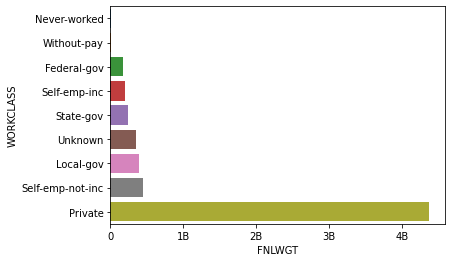

In [27]:
plt.ticklabel_format(style = 'plain', axis = 'x')
ax = plt.gca()
ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))

sns.barplot(y = 'WORKCLASS', x = 'FNLWGT', data = workclass_data, order = workclass_data.sort_values(by = ['FNLWGT'])['WORKCLASS'])

**2. EDUCATION & EDUCATION_NUM: Bar Chart**

**Insights:** The data has highest people from HS-grad education level, followed by Some-college and Bachelors covering 71% of the data

Note: EDUCATION_NUM column in the data gives us the order of education levels

**EDUCATION_NUM column is numerical representation of the ordering of the EDUCATION column**

In [28]:
order_list = ['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th', '12th', 'HS-grad', 'Some-college',
              'Assoc-voc', 'Assoc-acdm', 'Bachelors', 'Masters', 'Prof-school', 'Doctorate']

In [29]:
custom_dict = {order_list[i]: i for i in range(len(order_list))}

In [30]:
education_df = pd.DataFrame(data.groupby(['EDUCATION'])['FNLWGT'].agg('sum')).reset_index().\
               sort_values(by = ['EDUCATION'], key = lambda x: x.map(custom_dict)).reset_index(drop = True)

**Actual number of poeple in our dataset**

<AxesSubplot:xlabel='FNLWGT', ylabel='EDUCATION'>

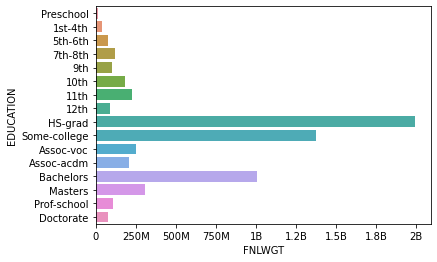

In [31]:
plt.ticklabel_format(style = 'plain', axis = 'x')
ax = plt.gca()
ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
sns.barplot(y = 'EDUCATION', x = 'FNLWGT', data = education_df, order = order_list)

**The column EDUCATION_NUM gives us the hierarchy of categories in EDUCATION column**

<AxesSubplot:xlabel='count', ylabel='EDUCATION_NUM'>

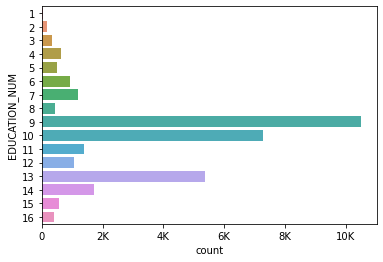

In [32]:
ax = plt.gca()
ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
sns.countplot(y = data['EDUCATION_NUM'], order = sorted(data['EDUCATION_NUM'].unique()))

**3. Marital Status: Bar Chart**

**Insights:** People with marital status Married-civ-spouse anf Never-married cover more than 80% of the data

In [33]:
marital_status_df = pd.DataFrame(data.groupby(['MARITAL_STATUS'])['FNLWGT'].agg('sum')).reset_index().\
               sort_values(by = ['MARITAL_STATUS']).reset_index(drop = True)

<AxesSubplot:xlabel='FNLWGT', ylabel='MARITAL_STATUS'>

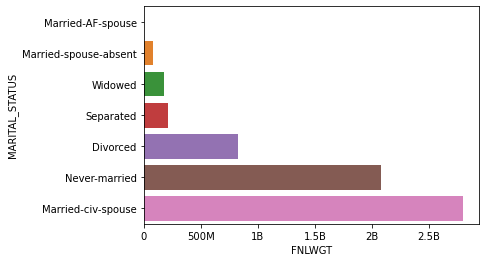

In [34]:
plt.ticklabel_format(style = 'plain', axis = 'x')
ax = plt.gca()
ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))

sns.barplot(y = 'MARITAL_STATUS', x = 'FNLWGT', data = marital_status_df, order = marital_status_df.sort_values(by = ['FNLWGT'])['MARITAL_STATUS'])

**4. Race: Bar Chart**

**Insights:** The data has more than 5 billion people from White Race

In [35]:
race_df = pd.DataFrame(data.groupby(['RACE'])['FNLWGT'].agg('sum')).reset_index().\
               sort_values(by = ['RACE']).reset_index(drop = True)

<AxesSubplot:xlabel='FNLWGT', ylabel='RACE'>

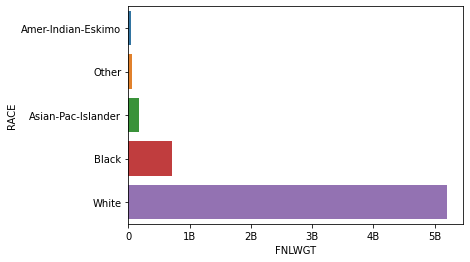

In [36]:
plt.ticklabel_format(style = 'plain', axis = 'x')
ax = plt.gca()
ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))

sns.barplot(y = 'RACE', x = 'FNLWGT', data = race_df, order = race_df.sort_values(by = ['FNLWGT'])['RACE'])

**5. Work-hours per week: Bar Chart**

**Insights:** Almost half of the people work for 40 hours per week

In [37]:
hours_per_week_df = pd.DataFrame(data.groupby(['HOURS_PER_WEEK'])['FNLWGT'].agg('sum')).reset_index().\
               sort_values(by = ['HOURS_PER_WEEK']).reset_index(drop = True)

<AxesSubplot:xlabel='HOURS_PER_WEEK', ylabel='FNLWGT'>

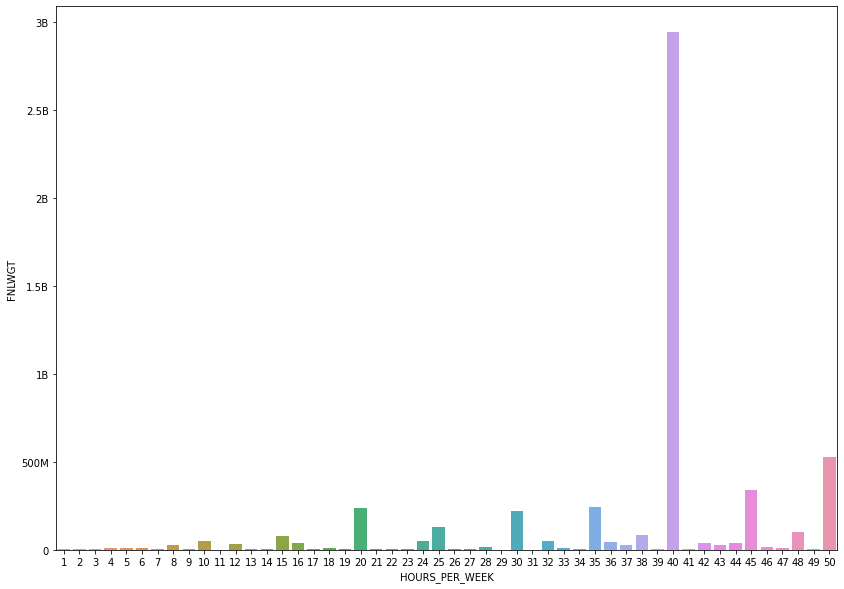

In [38]:
plt.figure(figsize = (14, 10))
plt.ticklabel_format(style = 'plain', axis = 'y')
ax = plt.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))

sns.barplot(x = 'HOURS_PER_WEEK', y = 'FNLWGT', data = hours_per_week_df, order = hours_per_week_df.sort_values(by = ['HOURS_PER_WEEK']).head(50)['HOURS_PER_WEEK'])

**6. Native countries: Bar Chart**

**Insights:** 5.5 billion people in the data are from the United States

In [39]:
native_country_df = pd.DataFrame(data.groupby(['NATIVE_COUNTRY'])['FNLWGT'].agg('sum')).reset_index().\
               sort_values(by = ['NATIVE_COUNTRY']).reset_index(drop = True)

<AxesSubplot:xlabel='FNLWGT', ylabel='NATIVE_COUNTRY'>

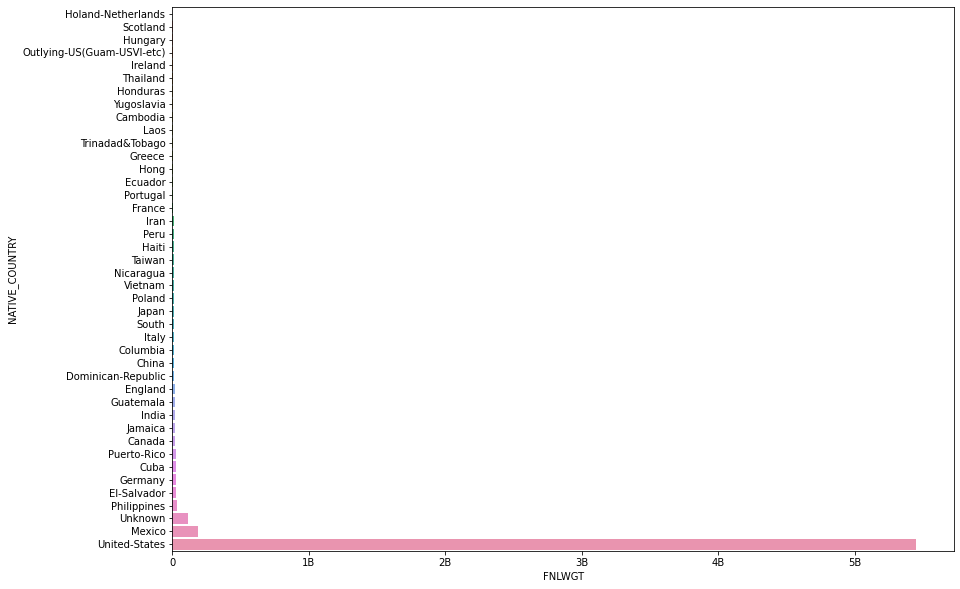

In [40]:
plt.figure(figsize = (14, 10))
plt.ticklabel_format(style = 'plain', axis = 'x')
ax = plt.gca()
ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))

sns.barplot(y = 'NATIVE_COUNTRY', x = 'FNLWGT', data = native_country_df, order = native_country_df.sort_values(by = ['FNLWGT']).head(50)['NATIVE_COUNTRY'])

**7. Income: target column**

**Insight:** The classes of target column are not imbalanced

In [41]:
data.groupby('INCOME')['FNLWGT'].agg('sum')

INCOME
<=50K    4701163700
>50K     1473735768
Name: FNLWGT, dtype: int64

<AxesSubplot:ylabel='FNLWGT'>

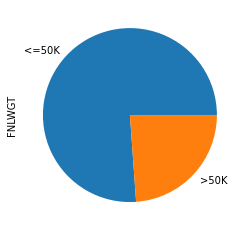

In [42]:
data.groupby('INCOME')['FNLWGT'].agg('sum').plot(kind ='pie')

**8. Plotting the population size for each type of record**

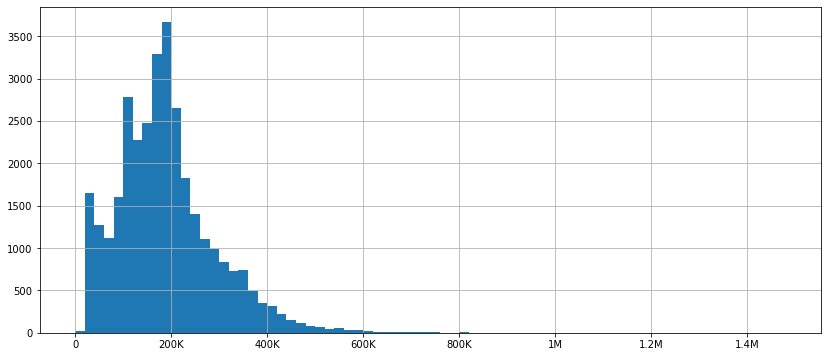

In [43]:
bin_values = np.arange(start = 0, stop = 1500000, step = 20000)
data['FNLWGT'].hist(bins = bin_values, figsize = [14, 6])

ax = plt.gca()
ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))

### Bivariate plots

**Executive Summary**

1. Only 11% of the females earn more than 50K USD as compared to the 30% of males
2. 58% of the people working under WORKCLASS Self-emp-inc are earning more than 50K USD
3. As expected, with better the education, the % of people earning more than 50K USD increases
4. A good proportion of Married-civ-spouse and Married-AF-spouse earn more than 50K USD
5. There are no females in the armed forces (present in the data)

**1. Distribution across Gender**

**Insights:** Only 11% of the females earn more than 50K USD as compared to the 30% of males

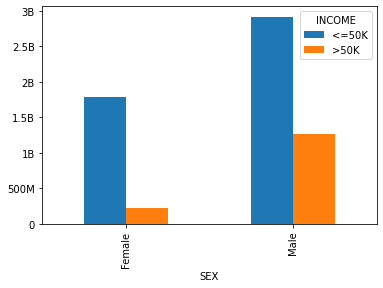

In [44]:
data.groupby(['SEX', 'INCOME'])['FNLWGT'].agg('sum').unstack().plot(kind = 'bar')

plt.ticklabel_format(style = 'plain', axis = 'y')
ax = plt.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))

In [45]:
pd.DataFrame((data.groupby(['SEX', 'INCOME'])['FNLWGT'].agg('sum') / data.groupby('SEX')['FNLWGT'].agg('sum') * 100)).rename(columns = {'FNLWGT': 'PERC'}).unstack()

PERC           
INCOME      <=50K       >50K
SEX                         
Female  89.164307  10.835693
Male    69.897202  30.102798

**2. Distribution across WORKCLASS**

**Insights:** 58% of the people working under WORKCLASS Self-emp-inc are earning more than 50K USD

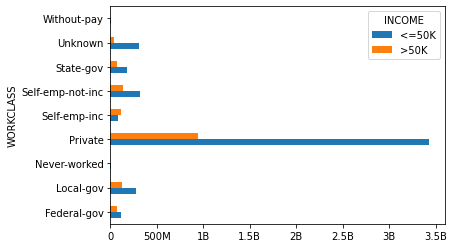

In [46]:
data.groupby(['WORKCLASS', 'INCOME'])['FNLWGT'].agg('sum').unstack().plot(kind = 'barh')

plt.ticklabel_format(style = 'plain', axis = 'x')
ax = plt.gca()
ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))

In [47]:
pd.DataFrame((data.groupby(['WORKCLASS', 'INCOME'])['FNLWGT'].agg('sum') / data.groupby('WORKCLASS')['FNLWGT'].agg('sum') * 100)).rename(columns = {'FNLWGT': 'PERC'}).unstack()

PERC           
INCOME                 <=50K       >50K
WORKCLASS                              
Federal-gov        60.901368  39.098632
Local-gov          69.812039  30.187961
Never-worked      100.000000        NaN
Private            78.539451  21.460549
Self-emp-inc       42.019110  57.980890
Self-emp-not-inc   70.308503  29.691497
State-gov          72.523279  27.476721
Unknown            89.870070  10.129930
Without-pay       100.000000        NaN

**3. Distribution across EDUCATION**

**Insights:** As expected, with better the education, the % of people earning more than 50K USD increases

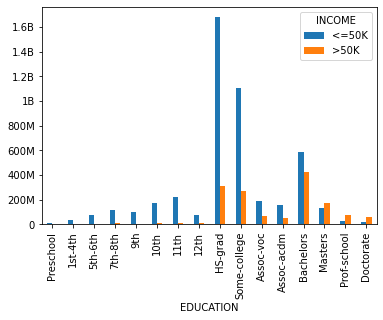

In [48]:
data.groupby(['EDUCATION', 'INCOME'])['FNLWGT'].agg('sum').unstack().loc[order_list].plot(kind = "bar")

plt.ticklabel_format(style = 'plain', axis = 'y')
ax = plt.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))

In [49]:
pd.DataFrame((data.groupby(['EDUCATION', 'INCOME'])['FNLWGT'].agg('sum') / data.groupby('EDUCATION')['FNLWGT'].agg('sum') * 100)).rename(columns = {'FNLWGT': 'PERC'}).unstack()

PERC           
INCOME             <=50K       >50K
EDUCATION                          
10th           93.318085   6.681915
11th           95.585630   4.414370
12th           91.940573   8.059427
1st-4th        96.537565   3.462435
5th-6th        96.509252   3.490748
7th-8th        94.229805   5.770195
9th            95.692993   4.307007
Assoc-acdm     75.423184  24.576816
Assoc-voc      73.831950  26.168050
Bachelors      58.082132  41.917868
Doctorate      24.868719  75.131281
HS-grad        84.432371  15.567629
Masters        43.756778  56.243222
Preschool     100.000000        NaN
Prof-school    26.783482  73.216518
Some-college   80.327040  19.672960

**4. Distribution across Marital Status**

**Insights:** A good proportion of Married-civ-spouse and Married-AF-spouse earn more than 50K USD. Also, there are no females in the armed forces (present in the data)

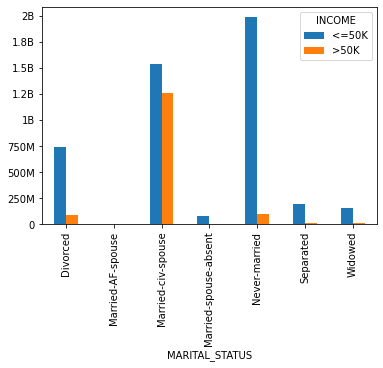

In [50]:
data.groupby(['MARITAL_STATUS', 'INCOME'])['FNLWGT'].agg('sum').unstack().plot(kind = "bar")

plt.ticklabel_format(style = 'plain', axis = 'y')
ax = plt.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))

In [51]:
pd.DataFrame((data.groupby(['MARITAL_STATUS', 'INCOME'])['FNLWGT'].agg('sum') / data.groupby('MARITAL_STATUS')['FNLWGT'].agg('sum') * 100)).rename(columns = {'FNLWGT': 'PERC'}).unstack()

PERC           
INCOME                     <=50K       >50K
MARITAL_STATUS                             
Divorced               89.593789  10.406211
Married-AF-spouse      61.548387  38.451613
Married-civ-spouse     55.048278  44.951722
Married-spouse-absent  93.293989   6.706011
Never-married          95.376090   4.623910
Separated              93.429049   6.570951
Widowed                92.156459   7.843541

### Other checks

None of the columns are highly correlated

In [54]:
corr_output = compute_correlation(data)

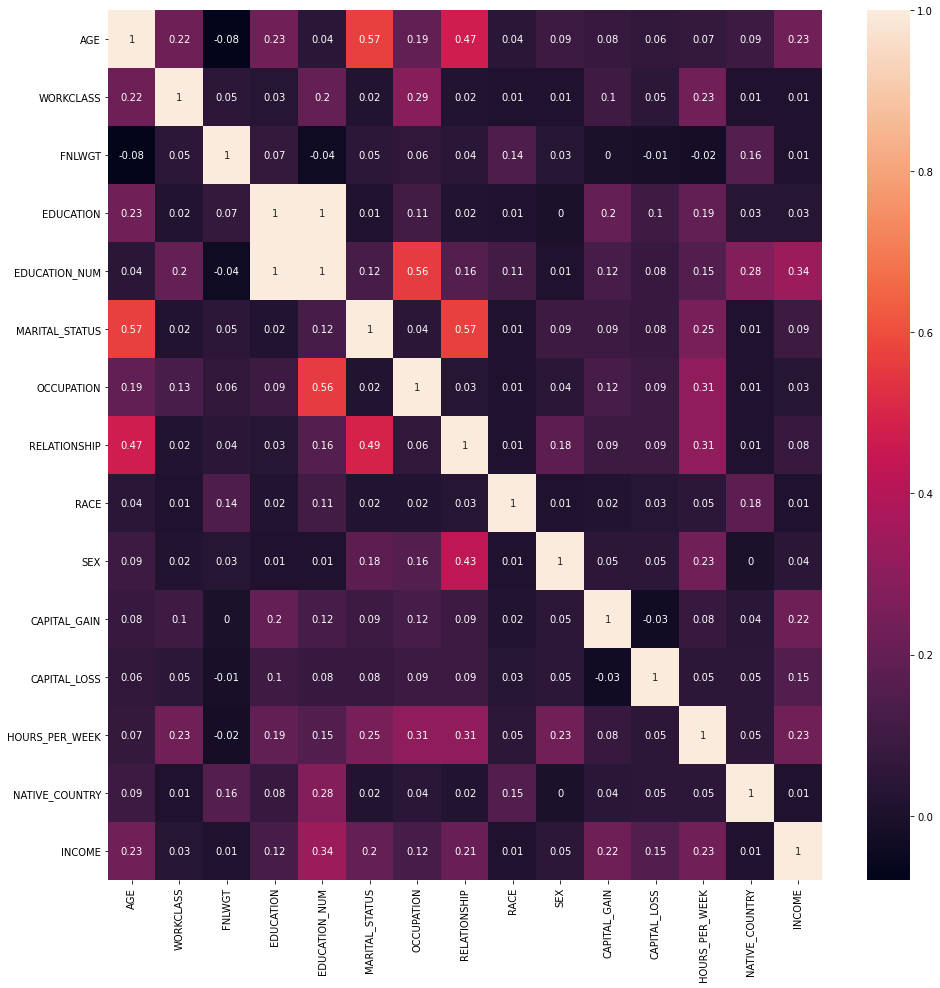

In [55]:
fig, ax = plt.subplots(figsize=(16,16))
sns.heatmap(corr_output, annot=True)
plt.show()

#### Outlier identification and treatment

Since each row in the data represents x number of people (FNLWGT column), we cannot obtain the outliers as they represent 